In [3]:
import sys
sys.path.append('..')

In [4]:
import numpy as np
from qca.chain_qw.thirring import Thirring
from matplotlib import pyplot as plt
from qca.util.util import normalize, index_to_x
import seaborn as sns

In [5]:
sns.set_theme()

In [6]:
def print_pk(qca, k0):
    pk = qca.get_pk(i=0)
    plt.xlabel('k')
    plt.ylabel(r'$\vert{c_k}\vert^2$')
    plt.title('Mode decomposition')
    plt.xticks([k0, k0-np.pi, -k0, -k0+np.pi], [r'$k_0$', r'$k_0-\pi$', r'$-k_0$', r'$\pi-k_0$'])
    plt.plot(np.arange(-L, L)*np.pi/L, np.abs(pk)**2)
    
def plot_px(qw, x1, x2):
    ps = []
    #purity = []
    for i in range(qw.n_particles):
        ps_i = qw.get_px(i)
    #    purity_i = qw.get_purity(0)
        ps.append(ps_i)
    #    purity.append(purity_i)
    ps = sum(ps)
    plt.title('Position probability distribution')
    plt.xlabel('x')
    plt.ylabel('p(x)')
    #for i in range(qw.n_particles):
    #    print(f'P{i+1}={np.real(purity[i]):.2f}', end=' ')
    #print()
    p = plt.plot(range(-qw.L, qw.L), ps)
    plt.xlim([x1, x2])
    return p

def coarse_grain_state(L, psi):
    psi = psi.reshape([2*L, 2])
    rho = psi @ psi.T.conj()
    return rho

def coarse_grain_unitary(L, theta):
    assert L%2 == 0, "L should be even"
    return Thirring._get_one_particle_W(int(L/2), 2*theta)

# Coarse graining

In [7]:
# gaussian packet
n = 1
chi = 0
theta = 0.2
L = 1000
qca = Thirring(L=L, n_particles=n, theta=theta, chi=chi) 

In [8]:
k0s = [0.2]
x0s = [-200]
sigma_k_s = [0.02]
signs = [1]
qca.psi = qca.in_state(k0s=k0s, x0s=x0s, sigma_k_s = sigma_k_s,signs = signs)

CPU times: user 1h 43min 12s, sys: 2min 26s, total: 1h 45min 38s
Wall time: 19min 59s


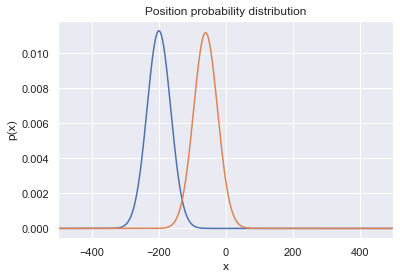

In [9]:
%%time
ds = []
ds_wrong = []
num_steps = 100
step_size = 1
Uir = np.linalg.matrix_power(coarse_grain_unitary(L, np.cos(k0s[0])*theta), step_size)
#Uir_wrong = np.linalg.matrix_power(coarse_grain_unitary(L, np.cos(k0s[0])*theta), step_size)
rho_app = coarse_grain_state(L, qca.psi)
#rho_app_wrong = coarse_grain_state(L, qca.psi)
xmin = -500
xmax = 500
plot_px(qca, -2, 120)
for i in range(num_steps):
    rho_ex = coarse_grain_state(L, qca.psi)
    ds.append(np.linalg.norm(rho_app - rho_ex, 'nuc')/2)
    #ds_wrong.append(np.linalg.norm(rho_app_wrong - rho_ex, 'nuc')/2)
    qca.evolve(2*step_size)
    rho_app = Uir @ rho_app @ Uir.T.conj()
    #rho_app_wrong = Uir_wrong @ rho_app_wrong @ Uir_wrong.T.conj()
plot_px(qca, xmin, xmax)

In [10]:
sns.color_palette("hls",8)

[(0.86, 0.3712, 0.33999999999999997),
 (0.86, 0.7612000000000001, 0.33999999999999997),
 (0.5688000000000001, 0.86, 0.33999999999999997),
 (0.33999999999999997, 0.86, 0.5012000000000001),
 (0.33999999999999997, 0.8287999999999999, 0.86),
 (0.33999999999999997, 0.43879999999999986, 0.86),
 (0.6311999999999998, 0.33999999999999997, 0.86),
 (0.86, 0.33999999999999997, 0.6987999999999996)]

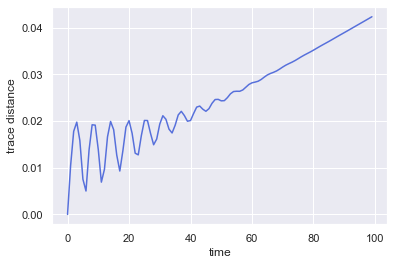

In [11]:
ns = np.arange(0,step_size*num_steps, step_size)
plt.plot(ns, ds, color=sns.color_palette("hls", 8)[5])
#plt.plot(ns, 4**3*1e-8*ns)
#plt.plot(range(num_steps), ds_wrong, label='zero mass')
plt.ylabel('trace distance')
plt.xlabel('time')
#plt.legend()
plt.savefig('mass_renormalization_2.pdf')
plt.show()

CPU times: user 2h 52min 24s, sys: 2min 51s, total: 2h 55min 15s
Wall time: 37min 10s


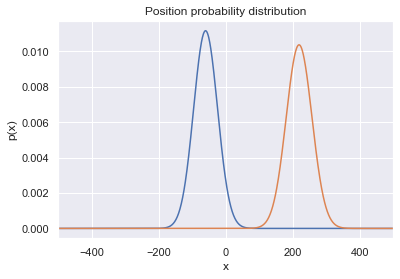

In [12]:
%%time
ds = []
sigma = []
num_steps = 200
step_size = 1
Uir = np.linalg.matrix_power(coarse_grain_unitary(L, theta), step_size)
rho_app = coarse_grain_state(L, qca.psi)
xmin = -500
xmax = 500
plot_px(qca, -2, 120)
for i in range(num_steps):
    rho_ex = coarse_grain_state(L, qca.psi)
    px = qca.get_px(0)
    x_mean = sum([px[i]*index_to_x(i, L) for i in range(2*L)])
    sigma.append(np.sqrt(sum([px[i]*index_to_x(i, L)**2 for i in range(2*L)])-x_mean**2))
    ds.append(np.linalg.norm(rho_app - rho_ex, 'nuc')/2)
    qca.evolve(2*step_size)
    rho_app = Uir @ rho_app @ Uir.T.conj()
plot_px(qca, xmin, xmax)